In [19]:
import datetime
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from db_utils.db_queries import sql_all_reports_with_weather
# from db_utils.mysql_db_connection import get_mysql_connection

from webscraping.scrape_fishing_data import clean_string

## Read and format the data

In [92]:
fishing_data = pd.read_csv("./raw_fishing_data.csv")

In [93]:
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


In [94]:
DATE_PATTERN = re.compile(r"\d+/\d+/\d+")

# match times like 3:30pm or 3:40 am
TIME_PATTERN = re.compile(r"\d+:\d+\s*(pm|am)", re.IGNORECASE)

In [95]:
def replace_dates(post):
    return DATE_PATTERN.sub("DATE__STAMP", post)

def replace_times(post):
    return TIME_PATTERN.sub("TIME__STAMP", post)

In [96]:
replace_dates("does 3/10/2020 sound right? how about 2020/10/3?")

'does DATE__STAMP sound right? how about DATE__STAMP?'

In [97]:
replace_times("lets meet around 12:40PM. Wait, does 1:45 Am work?")

'lets meet around TIME__STAMP. Wait, does TIME__STAMP work?'

In [99]:
# convert the date to a date object for consistency in our analysis + make pandas happy
fishing_data.loc[:, 'date_posted'] = pd.to_datetime(fishing_data.loc[:, 'date_posted'], format="%Y-%m-%d", cache=True)

# convert times and dates to a common value to reduce vocabulary size.
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(replace_dates)
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(replace_times)

# clean punctuation from the post bodies. makes our lives harder and doesnt contribute much
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(clean_string)


## Check for duplicate rows 

In [100]:
fishing_data.loc[fishing_data.duplicated(subset=['headline', 'post_body', 'date_posted'], keep=False)].sort_values("date_posted")

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
2548,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2547,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2478,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2477,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2354,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2353,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2336,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2335,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2332,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96
2331,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96


There are 13 duplicate posts that leaked into the data. We'll get rid of these so they don't skew any of our analysis.

In [101]:
fishing_data = fishing_data.drop_duplicates().reset_index(drop=True)
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


## Duplicate dates

In [102]:
# are there multiple posts for any days?
post_counts = fishing_data.date_posted.value_counts()
post_counts[post_counts >= 2]

2017-09-26    9
2017-04-30    9
2018-04-21    7
2017-04-28    7
2017-12-05    7
             ..
2014-07-10    2
2019-07-10    2
2014-07-13    2
2013-08-15    2
2007-07-29    2
Name: date_posted, Length: 410, dtype: int64

Is it concerning that dates are duplicated? Let's check one of the dates that has 9 posts.

In [103]:
sample_date = pd.Timestamp(datetime.date(2017, 9, 26))
duplicate_date_example = fishing_data.loc[fishing_data.date_posted == sample_date]
duplicate_date_example

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
498,2017-09-26,Excellent Start Kimura 8 Day,We departed Sunday on our annual Gary Kimura 8...,63.0,69.92,78.0,0.0,10.0,10.0,29.82
499,2017-09-26,beautiful dorados today,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
500,2017-09-26,beautiful yellowtail,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
501,2017-09-26,happy camper,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
502,2017-09-26,YELLOWTAIL BONANZA,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
503,2017-09-26,Matt,Matt brings in a beautiful Yellowtail,63.0,69.92,78.0,0.0,10.0,10.0,29.82
504,2017-09-26,Alex,Nice yellow today,63.0,69.92,78.0,0.0,10.0,10.0,29.82
505,2017-09-26,Robert,Robert says Hello to all my friends,63.0,69.92,78.0,0.0,10.0,10.0,29.82
506,2017-09-26,trip 1722 Jackpot winners,First place Tim Brown 57 8 Second place Vince ...,63.0,69.92,78.0,0.0,10.0,10.0,29.82


There seem to be days where the crew posts many times, sometimes without a post body. It's likely that these are accompanied by pictures on the actual site since the headlines are things like, `Matt brings in a beautiful Yellowtail`, though we didn't webscrape photos. More posts in a day may be an indicator of good fishing conditions. 

## When do posts happen?

#### Let's see how posts are distributed by year

In [104]:
# What is the earliest post and the most recent post by date?
sorted_dates = fishing_data.date_posted.sort_values()
sorted_dates.iloc[0], sorted_dates.iloc[-1]

(Timestamp('2005-06-19 00:00:00'), Timestamp('2020-12-19 00:00:00'))

In [105]:
# uncomment this to see just the numbers per year 
# (useful for spotchecking the bar plot since more plot options = room for error)

# fishing_data.date_posted.dt.year.value_counts()

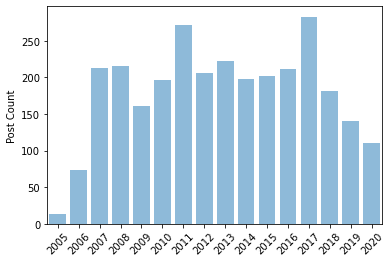

In [106]:
time_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(2005, 2020 + 2),
    "align":  "left"
}
plt.hist(fishing_data.date_posted.dt.year, **time_hist_options)
plt.ylabel("Post Count")
plt.xticks(time_hist_options['bins'], rotation=45)
plt.xlim([2004.5, 2020.5]);

Posts were fairly consistent in the late 2000s and 2010s, though this is clear dropoff in recent years. Drops in 2020 were almost certainly correlated with covid though there was an existing downward trend.

Note: The average post per day is less than 1 for every year in the dataset. Because the crew didn't post every day, it's likely that good days are overrepresented.

#### What about the distribution by month? Is there seasonality to the posts?

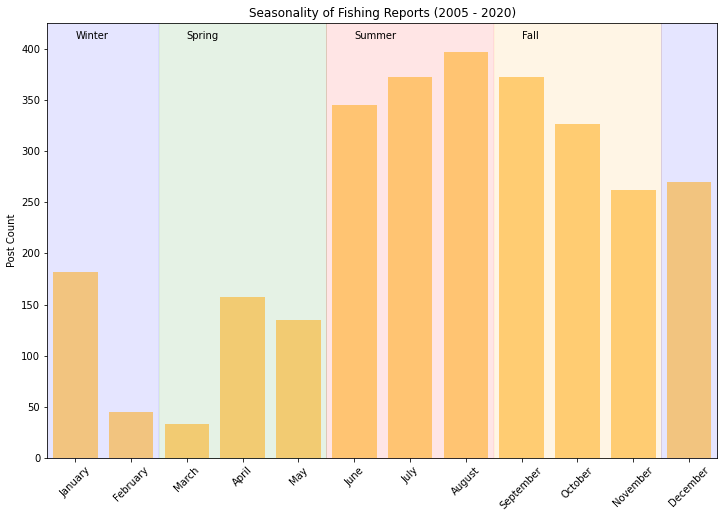

In [107]:
plt.figure(figsize=(12, 8))
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

month_hist_options = {
    "alpha":  0.5,
    "color":  "orange"
}

month_counts = fishing_data.date_posted.dt.month.value_counts().sort_index()

plt.bar(month_counts.index, month_counts.values, **month_hist_options)
plt.ylabel("Post Count")
plt.xticks(month_counts.index, labels=month_labels, rotation=45);


# Custom fill patterns to emphasize seasons
plt.fill_between([2.5, 5.49], 500,  alpha=0.1, color='green',  label='Spring')
plt.fill_between([5.5, 8.49], 500,  alpha=0.1, color='red',    label='Summer')
plt.fill_between([8.5, 11.49], 500, alpha=0.1, color='orange', label='Fall')
plt.fill_between([0, 2.49], 500,    alpha=0.1, color='blue',   label='Winter')
plt.fill_between([11.5, 12.5], 500, alpha=0.1, color='blue')

plt.annotate("Winter", [1, 410])
plt.annotate("Spring", [3, 410])
plt.annotate("Summer", [6, 410])
plt.annotate("Fall",   [9, 410])

plt.title("Seasonality of Fishing Reports (2005 - 2020)");
plt.ylim([0, 425])
plt.xlim([0.5, 12.5]);

#plt.savefig("post_seasonality.png", dpi=500);

Though posts aren't necessarily equivalent to business activity, this plot suggests that the fishing business may be more active in hotter months. This makes intuitive sense since we wouldn't expect people to be out in the rain or cold to catch fish, especially when the waters may be choppy or otherwise le.

### Rain patterns over the years

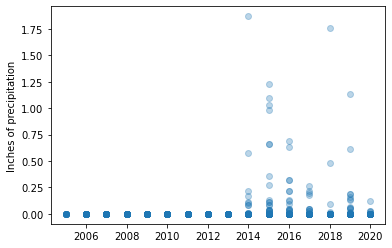

In [108]:
plt.scatter(fishing_data.date_posted.dt.year, fishing_data.inches_precip, alpha=0.3)
plt.ylabel("Inches of precipitation");

Before 2014 there is no rain data. Either the site we scraped weather data from didn't have correct measurements of the rain or we got unlucky and none of the posts occurred on days where there was rain. Given that there aren't many posts during rainy months, the latter is possible. We shouldn't use rain for anything serious in our analysis.

## Daily Temperatures

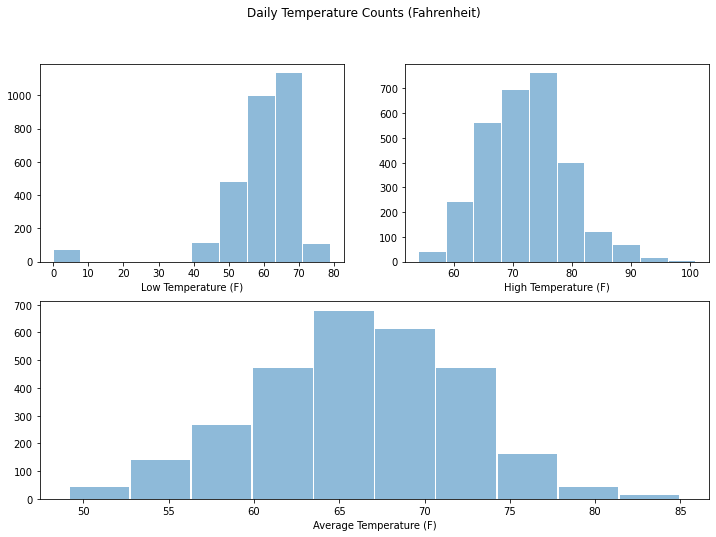

In [109]:
# thanks for the grid help: 
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
import matplotlib.gridspec as gridspec

temp_plot_options = {
    "alpha":  0.5,
    "rwidth": 0.97
}

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 8))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.suptitle("Daily Temperature Counts (Fahrenheit)")

plt.hist(fishing_data.low_temp, **temp_plot_options)
plt.xlabel("Low Temperature (F)")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.hist(fishing_data.high_temp, **temp_plot_options)
plt.xlabel("High Temperature (F)")

ax = plt.subplot(gs[1, :]) # row 1, span all columns
plt.hist(fishing_data.avg_temp, **temp_plot_options)
plt.xlabel("Average Temperature (F)");

The daily low temperatures have outlier values near 0. San Diego doesn't randomly hit sub-freezing temperatures, skipping everything from 32 down to 0, so we can be sure these are errors in the weather site's data.

As for the rest of the temperatures, the average and high look well-behaved. It may be worth looking for relationships between temperature and post content.

## What are the posts about?

For a first pass, we can simply look at the top words used (ignoring filler words)

In [110]:
# We'll ignore these words. They're too common to be useful
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
       'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
       'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
       'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
       'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
       'just', 'don', 'should', 'now']

stopwords = set(stopwords)

In [111]:
all_posts = " ".join(fishing_data.post_body.values)

tokens = all_posts.lower().split()
tokens = [t for t in tokens if t not in stopwords]

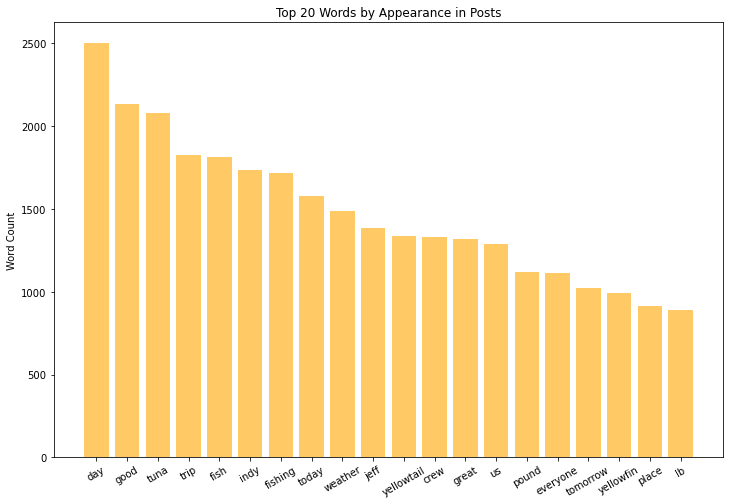

In [112]:
n = 20
top_n_words = pd.Series(tokens).value_counts().iloc[:n]

plt.figure(figsize=(12, 8))

plt.bar(top_n_words.index, top_n_words.values, alpha=0.6, color='orange')
plt.xticks(rotation=30)

plt.title(f"Top {n} Words by Appearance in Posts")
plt.ylabel("Word Count");

## Top Words in Fishing Reports

With the stopwords removed, we get mostly unique words with distinct meanings. It's a good sign that `tuna`, `yellowtail`, and `yellowfin` appear in the top words since we are more likely to be able to extract something interesting from the text. Additionally, `pound` and `lb` appearing are indicators that some posts are likely discussing the size of their catches. 

Given the top words look interesting, it may be worth looking for common phrases as well. We'll use a package called `gensim` to find these, but let's take a look at some of the math that's used under the hood to extract phrases. One way to think about phrase extraction is to think about common phrases as a collection of words that appear with each other by more than random chance. For example, the phrase "fishing is cool" is much less distinct than the phrase, "yellowfin tuna". 

"Yellowfin tuna" is a distinct phrase since the two words appear together frequently and they form a set of words that has a specific meaning together than individually. We'd like a sytematic way to find such phrases. But how? A mathematical way to approach this problem is to look at the *Pointwise Mutual Information* of word pairs.

### Beyond Single Words: Phrase Finding with Pointwise Mutual Information (PMI)

Roughly, PMI in the context of phrase finding can be thought of as measuring how associated two words are. It takes into account how often they appear altogether and compares this value to how often they appear together.

We define PMI as,

$$PMI(i, j) = log_2\frac{p(w_i, w_j)}{p(w_i)p(w_j)}$$

Where $i$ and $j$ are the indices of two words of interest, $p(w_i, w_j)$ is the probability of the two words occurring together, and $p(w_i)$ and $p(w_j)$ are the overall probabilities of the words occurring on any document (sometimes called the word frequency).


#### Limiting cases: two words are independent (not phrases)

We can expand the PMI formula using Bayes' rule like,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)p(w_j)}{p(w_i)p(w_j)} = log_2\frac{p(w_i|w_j)}{p(w_i)}$$

This is interesting because if $w_i$ and $w_j$ are independent, then $p(w_i|w_j) = p(w_i)$, so the calculation is simple,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{p(w_i)}{p(w_i)} = log_2 1 = 0$$

#### Limiting cases: two words always cooccur (extreme case of phrases)

If the words always occur together, say 99% of the time, then $p(w_i|w_j) \approx 0.99 $. Let's imagine the words themselves are relatively uncommon, so their individual frequency may be something like, $p(w_i) \approx \frac{1}{10,000}$. 

Expanding the PMI calculation,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{0.99}{\frac{1}{10,000}} \approx log_2 10,000 \approx 13.3 $$




#### High PMI -> likely to be a phrase, low PMI -> words probably aren't phrases 

In the two extreme cases, we see that independent words have a PMI of 0, while words that occur together all the time have a large PMI (13.3 in our example). This idea underpins a common strategy to find phrases. We will avoid reinventing the wheel, but keep this in mind as we move forward - there is no magic to the calculations we do. 


## Let's see if Gensim can find any interesting phrases

Referencing this thorough article on [topic modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels), we can get phrases from our text fairly simply. We'll start by dropping empty posts and doing light processing on the posts to make them into lists of words.

In [113]:
minimum_chars = 5
non_empty_posts = fishing_data.loc[fishing_data.loc[:, "post_body"].apply(lambda x: len(x.strip())) > minimum_chars]

In [114]:
split_docs = list(fishing_data.post_body.apply(lambda post: post.lower().split()).values)
print("Example documents: \n", split_docs[:2])

Example documents: 
 [['we', 'were', 'on', 'the', 'hunt', 'for', 'yellowtail', 'today', 'but', 'never', 'able', 'to', 'connect', 'we', 'covered', 'a', 'lot', 'of', 'water', 'for', 'a', 'handful', 'of', 'fish', 'were', 'not', 'giving', 'up', 'on', 'yellowtail', 'tomorrow', 'is', 'a', 'new', 'day', 'wish', 'us', 'luck', 'brian', 'indy', 'crew'], ['searched', 'for', 'yellowtail', 'again', 'today', 'to', 'find', 'non', 'biters', 'good', 'action', 'on', 'bass', 'barracuda', 'and', 'bonito', 'for', 'our', 'efforts', 'well', 'be', 'traveling', 'up', 'to', 'be', 'home', 'on', 'sunday', 'nice', 'weather', 'for', 'our', 'travels', 'brian', 'indy', 'crew']]


Here we set up the code to find phrases in our documents. Notice that scoring parameter is [`npmi`](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Normalized_pointwise_mutual_information_(npmi)). It's basically the same as the PMI we talked about before, though normalized to have scores in the range [-1, 1]. A higher threshold means that it takes more for words to get merged into phrases, thus there will be less of them. This can be tuned for your problem, but I'll run with 0.5.

In [115]:
import gensim

In [116]:
phrase_options = {
    "scoring": "npmi",
    "threshold": 0.5,
    "common_terms": stopwords
}

# Build the bigram and trigram models
bigram  = gensim.models.Phrases(split_docs, min_count=5, **phrase_options) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[split_docs], **phrase_options)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [117]:
def apply_phraser_to_doc(doc):
    """
    given a list of strings like,
    
    ['hi', 'how', 'are', 'you']
    
    returns the same list with any phrases merged together via a "_" character (gensim default).
    
    PS: will combine up to ~4 words together, though it can go higher depending on stopword usage
    """
    return trigram_mod[bigram_mod[doc]]

In [118]:
# what phrases are in the first post?
[word for word in apply_phraser_to_doc(split_docs[0]) if "_" in word]

['covered_a_lot_of_water', 'wish_us_luck', 'indy_crew']

## Inspecting the phrases 

Now that we have a way to extract common phrases, let's count all of the phrases that showed up.

In [119]:
split_phrased_docs = [apply_phraser_to_doc(doc) for doc in split_docs]

In [120]:
joined_phrased_docs = [" ".join(doc) for doc in split_phrased_docs]

In [121]:
# combine every post into one, split it into words, then keep the phrases
all_tokens = " ".join(joined_phrased_docs).split()

all_phrases = [word for word in all_tokens if "_" in word]

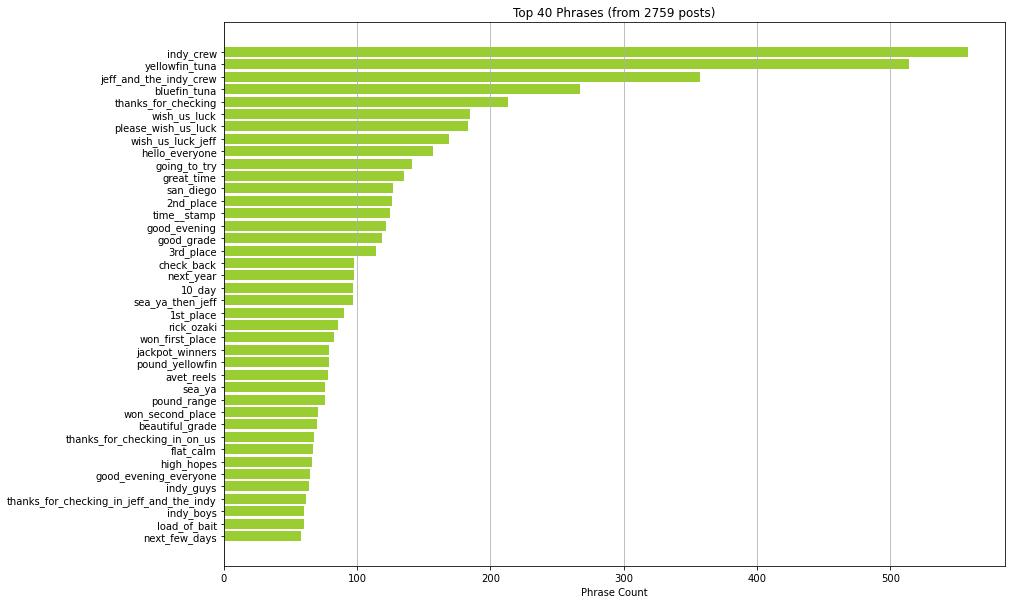

In [122]:
n = 40
top_n_phrases = pd.Series(all_phrases).value_counts().iloc[:n]

plt.figure(figsize=(14, 10))

plt.barh(top_n_phrases.index, top_n_phrases.values, color='yellowgreen')
plt.gca().invert_yaxis() # prefer decreasing order of the bars

plt.title(f"Top {n} Phrases (from {len(non_empty_posts)} posts)")
plt.xlabel("Phrase Count")

plt.grid(axis='x');

## What do these phrases mean?

For some phrases, the meaning is clear. `bluefin_tuna` and `yellowfin_tuna` at the top are clear indications of 
San Diego's reputation as a hotbed for tuna fishing holding true. For others, it may be useful to read a few posts and understand the context of the phrase.

We'll define a helper function to print a few examples of the more mysterious phrases in their original context.

In [ ]:
def print_phrase_with_context(phrase, num_docs):
    """
    prints the first `num_docs` documents with the phrase highlighted
    
    phrase: str, "_" delimiter removed
    """
    containing_posts = non_empty_posts.loc[non_empty_posts.post_body.apply(lambda post: phrase in post.lower()), "post_body"].values
    
    color_code = "\x1b[43;1m" # ANSI highlight background with yellow. ugly but draws the eye well
    for i, post in enumerate(containing_posts[:num_docs]):
        print(f"Example {i + 1}:")
        print(post.lower().replace(phrase, f"{color_code}{phrase}\x1b[0m"), "\n")

#### Phrase analysis: `indy_crew`

Seems to simply be part of the signature of the crew when they create a post. One of the boats is called the Independence, so this is shorthand.

In [ ]:
print_phrase_with_context("indy crew", num_docs=3)

#### Phrase analysis: `2nd_place`
looks like a phrase that comes up in discussing the results of fishing trips, where an individual's haul gives them a placement in a trip-wide fishing contest. Neat!

Note: we stripped all punctuation in an early step to make processing steps easier. This likely explains why some of the sentences are hard to read at times. This is a choice that can be experimented with, but I'll hold my ground for now.

In [ ]:
print_phrase_with_context("2nd place", num_docs=3)

#### Phrase analysis: `pound_range`

A common part of the fishing reports is the sizes of fish that were being caught. These types of posts may be a useful way to extract fishing conditions in later analysis.

In [ ]:
print_phrase_with_context("pound range", num_docs=3)

## Phrases are interesting but they don't provide the whole picture.

# TODO: rewrite this
Perhaps what would be better is to explore how the phrases and other words are used to understand the types of conversations that happen in a more systematic way. One option for doing this is to run a topic model on the posts. 

## Topic Modeling
Topic models are a class of generative language models where you suppose that each post is a mixture of topics. A topic is a distribution over words, thus allowing you to quantify questions like, "What words are likely to be spoken given that the topic of conversation is "weather conditions at sea". There are many topic models out there, but the original was Latent Dirichlet Allocation (LDA). 

LDA has a rich history and is still being developed into derivative models to this day, but let's keep it simple with this approximate idea: LDA is matrix factorization that takes a matrix of words counts on all of our posts and return 2 matrices: a topic distribution for each post, and a word distribution for each topic. 



## Cleaning the Data 

To get the most out of topic models when you're using them to explore some texts, it helps to clean the input to emphasize patterns of language that you're interested in observing. For example, there are many words in the English language that act as a glue to piece together the words we really care about. Many of these words are in our previous stopword list. We can remove them from our topic model so that the patterns that are found can be among words and phrases that have more meaning than the uninteresting `and`, `of`, and `but`-type of words.

In [123]:
dataset = split_phrased_docs

In [124]:
def remove_stopwords(split_text):
    return list(filter(lambda word: word not in stopwords, split_text))

# remove_stopwords does exactly what it sounds like
remove_stopwords(['hello', 'and', 'but', 'of', 'world'])

['hello', 'world']

In [125]:
# clean stopwords
# apply the function to every post
clean_dataset = list(map(remove_stopwords, dataset))

# remove empty or short posts
# filter removes short posts
minimum_words = 5
clean_dataset = list(filter(lambda split_post: len(split_post) > minimum_words, clean_dataset))

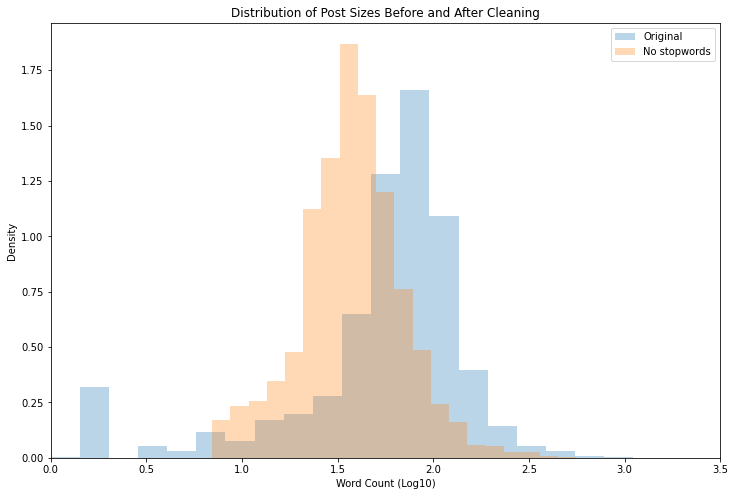

In [126]:
original_sizes = np.array(list(map(len, dataset)))
clean_sizes    = np.array(list(map(len, clean_dataset)))

plt.figure(figsize=(12, 8))

count_plot_config = {
    "alpha": 0.3,
    "bins": 20,
    "density": True
}

# necessary to avoid taking the log of 0 if there are empty posts
# spoiler: there are empty posts
smoothing_factor = 1

plt.hist(np.log10(original_sizes + smoothing_factor), label="Original", **count_plot_config);
plt.hist(np.log10(clean_sizes    + smoothing_factor), label="No stopwords", **count_plot_config);

plt.xlim([0, 3.5])
plt.xlabel("Word Count (Log10)")
plt.ylabel("Density")
plt.title("Distribution of Post Sizes Before and After Cleaning")
plt.legend();

### TODO: There should be a note here explaining why this is useful

In [127]:
clean_dataset[0]

['hunt',
 'yellowtail',
 'today',
 'never',
 'able',
 'connect',
 'covered_a_lot_of_water',
 'handful',
 'fish',
 'giving',
 'yellowtail',
 'tomorrow',
 'new',
 'day',
 'wish_us_luck',
 'brian',
 'indy_crew']

## Setting up the Topic Model - Asymmetric LDA


In [128]:
import gensim
import gensim.corpora as corpora

In [129]:
# Create Dictionary
id2word = corpora.Dictionary(clean_dataset)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in clean_dataset]

In [130]:
n_topics = 20

In [131]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=12321,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

## TODO: Explain this plot and give context. Is this learned or is it set? Provide interpretation

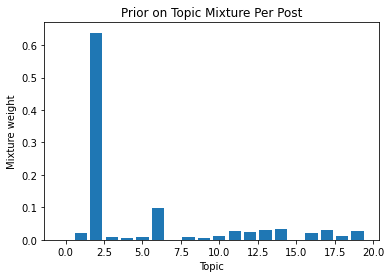

In [132]:
topic_prior = lda_model.alpha
topic_prior /= topic_prior.sum()

plt.bar(np.arange(n_topics), topic_prior)
plt.xlabel("Topic")
plt.ylabel("Mixture weight")

plt.title("Prior on Topic Mixture Per Post");

In [133]:
vocab = [word for key, word in id2word.items()]

In [134]:
topic_df = pd.DataFrame(lda_model.get_topics())
topic_df.columns = vocab
topic_df.head(2)

,able,brian,connect,covered_a_lot_of_water,day,fish,giving,handful,hunt,indy_crew,...,caps,generated,holders,liberty,masks,realize,rollos,worthwhile,applies,behold
0,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,...,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103
1,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,...,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021


In [135]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/anaconda3/envs/data-science-environment/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from pyLDAvis import save_html

# save_html(vis, "lda_viz.html")

# TODO: Use topic matrix like word vectors. Use word similarity to find fish names?
# TODO: documents that have high theta values for interesting topics?
# TODO: find a way to extract fish species and measure mentions
# TODO: weather vs post content
# TODO: import el nino data

conda install -c conda-forge spacy
conda install -c conda-forge spacy-lookups-data
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg

In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")

def print_doc_with_context(texts):
    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):
        # Do something with the doc here
        print([(ent.text, ent.label_) for ent in doc.ents])

In [10]:
fishing_data.post_body[:1]

0    We were on the hunt for Yellowtail today but n...
Name: post_body, dtype: object

In [11]:
doc_num = 2
print_doc_with_context(fishing_data.post_body[doc_num:doc_num + 1])

[('Another good day', 'DATE'), ('the morning', 'TIME'), ('Yellowfin Tuna', 'PERSON'), ('Yellowtail', 'PERSON'), ('Yellowtail', 'PERSON'), ('Brian Indy', 'PERSON')]


In [12]:
jargon = {
    "yft":  "yellowfin tuna",
    "reds": "red snapper/red cod",
    "bft":  "bluefin tuna",
    "ling": "lingcod",
    "yellowtailin":  "catching yellowtail",
    "yellowtailing": "catching yellowtail",
    "yella":   "yellowtail tuna",
    "yellas":  "yellowtail tuna",
    "flyline": "live bait",
    "kelps":   "kelp paddies",
    "albies":  "albacore"
}

In [13]:
OOV_words  = set()
fish_names = set()

In [16]:
for doc in nlp.pipe(fishing_data.post_body, disable=["parser"]):
    for tok in doc:
        if tok.is_oov:
            OOV_words.update({str(tok)})
            continue
        if tok.similarity(nlp.vocab["Yellowtail"]) >= 0.40:
            fish_names.update({str(tok).lower()})
            print(tok.lemma_, tok.ent_type_, )

yellowtail PERSON
fish 
Yellowtail WORK_OF_ART
yellowtail PERSON
barracuda 
bonito 
Yellowfin PERSON
Tuna PERSON
yellowtail PERSON
yellowtail PERSON
Yellowfin PERSON
Tuna PERSON
Yellowtail 
fish 
fish 
Yellowfin PERSON
Tuna PERSON
fish 
tuna 
fish 
fish 
yellowtail 
yellowtail 
yellowtail EVENT
Yellowfin PERSON
Tuna PERSON
fish 
fish 
Wahoo ORG
fish 
yellowtail 
Wahoo ORG
fish 
yellowfin 
yellowtail 
yellowfin 
wahoo 
tuna 
wahoo 
wahoo 
tuna 
wahoo 
yellowtail 
yellowtail PERSON
Wahoo ORG
Yellowfin PERSON
Tuna PERSON
yellowtail 
yellowtail 
fish 
yellowfin 
tuna 
wahoo 
Bluefin LOC
fish 
Bluefin PERSON
yellowtail PERSON
fish 
Wahoo ORG
fish 
Bluefin 
Bluefin ORG
bluefin PERCENT
yellowfin 
tuna 
yellowtail 
wahoo 
bluefin 
tuna 
fish 
bluefin 
yellowtail 
yellowfin 
wahoo 
dorado GPE
bluefin 
tuna 
bluefin 
tuna 
Bluefin PRODUCT
Tuna PRODUCT
Yellowfin 
tuna 
yellowtail PERSON
Yellowtail PERSON
Bonito 
fish 
yellowtail 
Yellowfin ORG
tuna 
tuna 
kelp 
kelp 
Dorado GPE
yellowtail GPE
Blu

fish 
fishery 
yellowfin PERSON
Yellowtail PERSON
Yellowfin 
Tuna 
Yellowfin NORP
Tuna NORP
Yellowfin 
Tuna 
yellowfin PERSON
Tuna PERSON
yellowtail PERSON
Tuna 
fish 
Tuna 
fish 
Wahoo PERSON
wahoo PERSON
sardine 
yellowtail 
Mahi EVENT
Mahi EVENT
yellowtail 
fish 
tuna 
wahoo 
yellowtail 
yellowfin 
tuna 
wahoo 
Wahoo ORG
tuna 
Wahoo 
Wahoo ORG
Tuna 
Wahoo 
Wahoo 
Tuna PERSON
Wahoo PERSON
Tuna PERSON
Yellowtail PERSON
Dorado GPE
yellowtail 
fish 
Wahoo TIME
Wahoo 
Wahoo TIME
yellowtail 
Tuna 
Wahoo ORG
Yellowtail PERSON
Wahoo 
Tuna 
Yellowtail 
Wahoo 
yellowtail LOC
fish 
Wahoo ORG
Tuna 
Tuna 
fish 
tuna 
fish 
Wahoo PERSON
Wahoo PERSON
Yellowfin PERSON
Tuna PERSON
Wahoo ORG
Wahoo 
Wahoo ORG
yellowtail PERSON
Sardine ORG
fish 
fish 
yellowtail 
fish 
wahoo 
yellowtail 
yellowtail PERSON
yellowfin 
wahoo 
yellowtail 
ahi 
wahoo 
yellowfin 
tuna 
fish 
fish 
fish 
Yellowfin PERSON
Tuna PERSON
Mahi 
Mahi 
fish 
Yellowtail 
Tuna 
Dorado LOC
yellowtail PERSON
Yellowfin PERSON
Tuna PERSON


wahoo 
Yellowfin PERSON
Tuna PERSON
Wahoo PERSON
Wahoo TIME
Yellowfin QUANTITY
Yellowfin PERSON
Dorado LOC
Wahoo ORG
yellowtail WORK_OF_ART
fish 
fish 
Dorado GPE
yellowtail PERSON
fish 
Wahoo PERSON
Tuna PERSON
yellowtail 
yellowtail GPE
wahoo ORG
yellowfin PERSON
sportfishing 
yellowtail PERSON
yellowtail 
Tuna 
Bluefin PERSON
Dorado GPE
fish 
fish 
Bluefin 
Tuna 
Bluefin PERSON
fish 
bluefin 
tuna 
bluefin 
bluefin 
Dorado GPE
dorado GPE
tuna 
bluefin 
tuna 
fish 
yellowtail 
dorado GPE
bluefin 
tuna 
bluefin 
tuna 
inshore 
tuna 
tuna 
yellowfin 
tuna 
fish 
fish 
tuna 
yellowtail 
yellowfin 
tuna 
mackerel 
yellowfin 
tuna 
yellowtail 
yellowfin ORG
yellowfin ORG
sardine 
bluefin ORG
tuna 
Yellowfin PERSON
Bluefin PERSON
Tuna PERSON
fish QUANTITY
fish 
Yellowfin PERSON
Tuna PERSON
Yellowtail PERSON
fish 
yellowtail GPE
tuna 
tuna 
yellowtail 
yellowtail 
yellowtail 
fish 
yellowtail GPE
Yellowfin PERSON
tuna 
tuna 
Wahoo ORG
sardine PERSON
fish 
Tuna PERSON
Yellowtail PERSON
Dorad

yellowtail 
fish 
tuna 
Wahoo ORG
fish 
tuna 
wahoo 
fish 
fish 
fish 
fish 
tuna 
Wahoo 
tuna 
Wahoo 
tuna 
wahoo 
fish 
fish 
fish 
Wahoo ORG
fish 
tuna 
tuna 
Wahoo PERSON
tuna 
fish 
wahoo 
fish 
sardine 
fish 
tuna 
Wahoo PERSON
fish 
fish 
fish 
Wahoo ORG
fish 
tuna 
fish 
fish 
fish 
Wahoo ORG
tuna 
tuna 
yellowfin 
tuna 
tuna 
yellowfin 
fish 
tuna 
tuna 
sardine 
fish 
sardine 
mackerel 
squid 
Wahoo PERSON
Wahoo ORG
fish 
tuna 
tuna 
Wahoo 
tuna 
tuna 
tuna 
fish 
fish 
tuna 
fish 
tuna 
tuna 
Wahoo ORG
fish 
tuna 
wahoo 
tuna 
wahoo 
tuna 
yellowfin 
tuna 
wahoo 
fish 
tuna 
fish 
fish 
Wahoo 
fish 
fish 
tuna 
tuna 
Yellowfin 
Tuna 
tuna 
tuna 
tuna 
tuna 
Wahoo ORG
tuna 
fish 
fish 
tuna 
Wahoo 
fish 
fish 
fish 
tuna 
Wahoo ORG
fish 
fish 
tuna 
wahoo 
fish 
tuna 
Wahoo ORG
tuna 
yellowfin 
tuna 
yellowfin 
yellowfin 
tuna 
yellowfin 
tuna 
yellowfin 
yellowfin 
tuna 
yellowtail 
yellowtail 
yellowtail 
Wahoo ORG
tuna 
Wahoo ORG
wahoo 
fish 
yellowtail 
fish 
Wahoo ORG
tu

yellowfin 
tuna 
yellowtail PERSON
yellowtail 
Wahoo ORG
wahoo ORG
tuna 
yellowfin 
tuna 
Dorado GPE
Dorado GPE
Dorado GPE
Dorado GPE
yellowtail PERSON
yellowtail 
sardine 
fish 
Dorado GPE
kelp 
Yellowfin PRODUCT
tuna 
yellowtail 
fish 
Dorado GPE
yellowfin 
fish 
bluefin 
tuna 
yellowtail 
fish 
fish 
Squid PRODUCT
tuna 
tuna 
tuna 
yellowtail 
dorado GPE
mackerel 
yellowtail 
bluefin 
tuna 
yellowfin 
tuna 
yellowtail 
wahoo 
dorado 
pargo 
yellowfin 
tuna 
Wahoo ORG
Pargo LOC
yellowtail 
tuna 
dorado 
yellowtail 
wahoo 
tuna 
dorado 
yellowtail 
wahoo 
yellowtail 
dorado 
bluefin 
tuna 
yellowfin 
dorado LOC
bluefin 
tuna 
yellowfin 
yellowfin 
yellowfin 
sardine 
yellowtail 
yellowfin 
tuna 
yellowfin 
tuna 
yellowtail 
bluefin 
tuna 
yellowfin 
sardine 
fish 
tuna 
Dorado GPE
fish 
fish 
yellowtail 
tuna 
dorado 
yellowfin 
tuna 
sardine 
Fish ORG
yellowfin 
fish 
tuna 
Fish ORG
yellowfin ORG
yellowfin ORG
yellowfin ORG
fish 
bluefin 
tuna 
yellowfin 
tuna 
tuna 
tuna 
Dorado GPE

yellowtail 
fish 
bluefin 
bluefin 
bluefin 
bluefin 
bluefin 
bluefin 
bluefin 
bluefin 
fish 
bluefin 
tuna 
bluefin 
bluefin 
bluefin 
fish 
fish 
yellowtail 
tuna 
bluefin 
tuna 
yellowtail 
squid 
fish 
sardine 
bluefin 
tuna 
yellowtail 
tuna 
fish 
yellowtail 
bluefin 
fish 
fish 
yellowtail 
fish 
bluefin 
tuna 
bluefin 
yellowtail 
yellowfin 
tuna 
sardine 
fish 
fish 
albacore 
yellowtail 
yellowtail 
bluefin 
tuna 
tuna 
Bluefin ORG
bluefin 
tuna 
yellowtail 
yellowtail 
fish 
fish 
bluefin 
albacore 
tuna 
yellowtail 
fish 
fish 
yellowtail 
fish 
Dorado GPE
yellowfin 
tuna 
Dorado LOC
yellowtail 
tuna 
fish 
tuna 
yellowtail 
yellowtail PERSON
yellowtail 
yellowtail 
yellowtail 
yellowtail 
fish 
yellowtail 
fish 
yellowtail 
yellowtail 
fish 
yellowtail 
yellowtail 
tuna 
yellowfin 
tuna 
yellowtail 
tuna 
tuna 
tuna 
yellowtail 
tuna 
tuna 
fish 
fish 
yellowtail 
tuna 
fish 
sardine 
fish 
fish 
yellowfin 
tuna 
fish 
fish 
fish 
fish 
fish 
fish 
tuna 
fish 
tuna 
tuna

fish 
bluefin 
albacore 
Bluefin ORG
tuna 
albacore 
bluefin 
yellowtail 
fish 
fish 
fish 
fish 
yellowtail 
albacore 
albacore 
bluefin 
albacore 
yellowtail 
fish 
yellowtail 
bluefin 
tuna 
bluefin 
fish 
bluefin 
albacore 
yellowtail 
yellowtail 
bluefin 
tuna 
albacore 
yellowtail 
sardine 
Bluefin 
Tuna 
tuna 
albacore 
yellowtail 
Fish PRODUCT
albacore 
bluefin 
tuna 
yellowtail 
tuna 
yellowtail 
fish 
Bluefin 
Tuna 
bluefin 
yellowtail 
albacore 
yellowtail 
yellowtail 
albacore 
yellowtail 
tuna 
yellowfin 
yellowfin 
yellowfin 
Fish 
Bluefin ORG
albacore 
albacore 
yellowtail 
fish 
albacore 
bluefin 
albacore 
bluefin 
tuna 
yellowtail 
yellowfin 
tuna 
yellowtail 
fish 
tuna 
yellowtail 
fish 
albacore 
bluefin 
albacore 
bluefin 
tuna 
yellowfin 
tuna 
albacore 
yellowtail 
yellowfin 
tuna 
tuna 
yellowfin 
yellowtail 
fish 
albacore 
bluefin 
fish 
yellowtail 
fish 
fish 
yellowtail 
yellowtail 
fish ORG
fish 
fish 
yellowtail 
yellowtail 
yellowtail 
fish 
yellowtail 


Halibut 
yellowtail 
yellowtail 
sardine 
albacore 
albacore 
yellowtail 
fish 
halibut 
albacore 
yellowtail 
yellowtail QUANTITY
yellowtail 
yellowtail 
sardine 
albacore 
fish 
fish 
fish 
fish 
yellowtail 
fish 
albacore 
fish 
yellowtail 
sardine 
mackerel 
yellowfin 
tuna 
yellowtail 
yellowtail 
sardine 
tuna 
yellowtail 
fish 
fish 
yellowtail 
tuna 
fish 
albacore 
fish 
tuna 
albacore 
fish 
fish 
albacore PERSON
albacore 
albacore 
fish 
fish 
albacore 
albacore 
fish 
Tuna 
fish 
yellowtail 
fish 
fish 
fish 
dorado 
yellowtail 
fish 
fish 
fish 
yellowtail 
bluefin 
albacore 
Tuna 
Yellowtail PERSON
albacore 
yellowtail PERSON
Tuna ORG
fish 
dorado LOC
tuna 
yellowtail 
albacore 
yellowtail 
fish 
fish 
yellowtail 
Tuna 
yellowtail 
fish 
mackerel 
sardine 
dorado LOC
yellowfin 
albacore 
albacore 
fish 
albacore 
Dorado GPE
yellowtail 
yellowtail ORG
yellowtail GPE
yellowtail 
fish 
fish 
yellowtail 
yellowtail 
dorado LOC
fish 
yellowtail 
yellowtail 
yellowtail 
dorado 

fish 
fish 
mackerel 
sardine 
tuna 
sardine 
sardine 
tuna 
sardine 
TUNA 
fish 
Tuna 
sardine 
Tuna 
Yellowfin PERSON
Tuna PERSON
fish 
yellowfin 
Tuna 
tuna 
fish 
yellowtail 
yellowfin PERSON
wahoo 
tuna 
fish 
sardine 
Yellowfin PERSON
Tuna PERSON
Wahoo ORG
Tuna 
squid 
Squid PRODUCT
Yellowfin PERSON
sardine 
fish 
tuna 
Tuna 
squid 
Yellowfin PERSON
fish 
fish 
yellowfin PERSON
sardine 
sardine 
yellowfin PERSON
yellowfin PERSON
sardine 
Yellowfin PERSON
Tuna 
yellowtail PERSON
snapper 
Pargo ORG
Pargo LOC
FISH ORG
yellowtail GPE
sardine 
yellowtail PERSON
yellowtail 
Tuna ORG
yellowtail 
tuna 
tuna 
fish 
Tuna 
Wahoo 
Tuna 
Tuna 
tuna 
yellowtail ORG
Yellowtail ORG
yellowtail 
Tuna 
sardine 
mackerel 
yellowtail PERSON
fish 
yellowtail PERSON
albacore 
Halibut PERSON
fish 
Wahoo 
Tuna PRODUCT
yellowfin PERSON
sardine 
Yellowfin 
Tuna 
yellowtail 
fish 
yellowfin ORG
fish 
sardine 
yellowfin PERSON
Yellowfin 
Wahoo ORG
fish 
fish 
yellowtail PERSON
yellowtail PERSON
yellowtail PE

sardine 
tuna 
fish 
tuna 
tuna 
tuna 
squid 
squid 
tuna 
tuna 
tuna 
wahoo 
tuna 
fish 
sardine 
skipjack 
mackerel 
tuna 
fish 
sardine 
yellowfin 
fish 
fish 
sardine 
skipjack 
tuna 
sardine 
fish 
sardine 
tuna 
tuna 
sardine 
tuna 
bluefin 
tuna 
Bluefin 
Tuna 
yellowtail 
Bluefin PERSON
Tuna PERSON
fish 
Bluefin 
tuna 
yellowtail 
Yellowfin PERSON
Tuna PERSON
yellowtail 
yellowtail PERSON
Bluefin LOC
Tuna LOC
fish 
tuna 
fish 


Out of vocabulary words (OOV) are those the model hasn't seen in training. Tracking these words from our own corpus is a great way to find jargon and misspellings. The more notable ones will be corrected by handle or added to a jargon mapping so we can explicitly convert the jargon to a more common phrase.

In [17]:
OOV_words

{'00AM',
 '00am',
 '052310',
 '052410',
 '052510',
 '052710',
 '0530am',
 '053110',
 '060410',
 '061610',
 '062010',
 '062310',
 '062410',
 '070410',
 '070910',
 '071010',
 '072910',
 '080310',
 '080810',
 '0814',
 '082010',
 '082610',
 '083110',
 '091210',
 '091910',
 '092610',
 '100810',
 '101310',
 '1090AM',
 '110210',
 '112410',
 '120810',
 '121910',
 '15am',
 '18ilb',
 '1904B',
 '1904C',
 '206Tuna',
 '28pounds',
 '2SP',
 '2Wahoo',
 '2sp',
 '30AM',
 '30Am',
 '30am',
 '30the',
 '35LB',
 '35lbclass',
 '40am',
 '45AM',
 '45am',
 '50SDS',
 '50ls',
 '5777',
 '59am',
 '5LB',
 '5yft',
 '600N',
 '6364',
 '6455',
 '6460',
 '6463',
 '6465',
 '6470',
 '66463',
 '6xs',
 '700XH',
 '71Lb',
 '7455',
 '7460',
 '7465',
 '74656',
 '7567',
 '7691',
 '7xs',
 '8Yellowfin',
 '8Yellowtail',
 '91450',
 '94150',
 '94151',
 'AFTCO',
 'ALBACORE',
 'ALBIES',
 'ALEXOPOULOS',
 'ALIJOS',
 'AVET',
 'Ablies',
 'Abshear',
 'Ackel',
 'Aftco',
 'Ahis',
 'Aiso',
 'Alajajyan',
 'Albies',
 'Albro',
 'Algaze',
 'Alijos',

In [18]:
fish_names

{'ahi',
 'albacore',
 'amberjack',
 'anchovy',
 'barracuda',
 'bluefin',
 'boated',
 'bonito',
 'crab',
 'croaker',
 'dorado',
 'dorados',
 'fish',
 'fishery',
 'flatties',
 'grouper',
 'groupers',
 'haddock',
 'halibut',
 'hamachi',
 'hammerheads',
 'inshore',
 'jigging',
 'kelp',
 'lingcod',
 'longfin',
 'mackeral',
 'mackerel',
 'mahi',
 'marlin',
 'pargo',
 'pelagic',
 'pollock',
 'rockfish',
 'salmon',
 'sardine',
 'sardines',
 'scad',
 'seabass',
 'seared',
 'shrimp',
 'skipjack',
 'snapper',
 'snappers',
 'sportfishing',
 'squid',
 'sushi',
 'swordfish',
 'tenderloin',
 'triggerfish',
 'tuna',
 'tunas',
 'wahoo',
 'wahoos',
 'yellowfin',
 'yellowtail'}